# Bert Partition

## Imports

In [2]:
!pip install transformers datasets evaluate wandb pip install gudhi strsimpy -q

DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import datasets
import gudhi as gd
import pickle as pkl
import gc

from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    AutoModelForMaskedLM,
    get_scheduler
)
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

from tqdm.auto import trange, tqdm
import pandas as pd

import wandb
import strsimpy

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

## Parameters

In [4]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
wandb.init(
    project='grammar-bert-model1',
    entity='grammar-bert'
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [7]:
SEQ_LEN = 64
BATCH_SIZE = 16
TEST_SIZE = 0.3
MLM_PROB = 0.15

#DATA_PATH = '/content/drive/MyDrive/nnlp/bert/biblioteka_prikluchenij_both_agr.csv'
DATA_PATH = "data/biblioteka_prikluchenij_both_agr.csv"
MODEL_NAME = 'DeepPavlov/rubert-base-cased'

## Data Preparation

In [8]:
df = pd.read_csv(DATA_PATH)

In [9]:
df

,Unnamed: 0,initial,polypers
0,0,«Опасный беглец».,« Опасный беглец » .
1,1,— Эта книга рассказывает о народной освободите...,— Эта книга рассказывает о народной освободите...
2,2,В середине прошлого века угнетенные народы Инд...,В середине прошлого века угнетенные народы Инд...
3,3,Колонизаторы душили всякое проявление свободно...,Колонизаторы душилиет всякое проявление свобод...
4,4,Свидетелем страшной расправы голландских колон...,Свидетелем страшной расправы голландских колон...
...,...,...,...
2298478,2298478,- Лида!,- Лида !
2298479,2298479,Аркадий Михайлович!,Аркадий Михайлович !
2298480,2298480,Олекса Мартынович!,Олекса Мартынович !
2298481,2298481,Тарас! - проговорил он тихим голосом в сильном...,Тарас ! - проговорил он тихим голосом в сильно...


### Levenstein

In [46]:
levenshtein = strsimpy.Levenshtein()

#for row in df.iterrows():

distance = []

for row in tqdm(df.iterrows()):

    distance.append(levenshtein.distance(
        row[1]["initial"],
        row[1]["polypers"]
    )
                   )

0it [00:00, ?it/s]

In [50]:
with open("lev_dist.pkl", "wb") as f:

    pkl.dump(distance, f)

### 

In [10]:
with open("lev_dist.pkl", "rb") as f:
    distance = pkl.load(f)

In [11]:
len(distance)

2298483

In [12]:
df = df.iloc[:len(distance), :]

df = df.assign(distance = distance)

In [13]:
df = df.loc[df["distance"] >= 7]

In [14]:
df

,Unnamed: 0,initial,polypers,distance
3,3,Колонизаторы душили всякое проявление свободно...,Колонизаторы душилиет всякое проявление свобод...,11.0
12,12,Ей принадлежат переводы произведений Элтона Си...,Ей принадлежат переводы произведений Элтона Си...,8.0
15,15,"Жизнь автора «Дон Кихота», полная событий, бое...","Жизнь автора « Дон Кихота » , полная событий ,...",7.0
16,16,"По призыву А. М. Горького, в 1932 году Э. И. В...","По призыву А . М . Горького , в 1932 году Э . ...",8.0
17,17,"Кроме того, она печатает короткие рассказы в ж...","Кроме того , она печатаетете короткие рассказы...",12.0
...,...,...,...,...
2298388,2298388,"Начальник охраны послал в Москву телеграмму, в...",Начальник охраны послалет в Москву телеграмму ...,7.0
2298401,2298401,"Когда шпион вошел в комнату, меня поразил его ...","Когда шпион вошел в комнату , меня поразилю ег...",8.0
2298406,2298406,"- Мы имеем также бесспорные доказательства, чт...",- Мы имеемете также бесспорные доказательства ...,8.0
2298438,2298438,"Чистенький городок, расположенный внизу, у сам...","Чистенький городок , расположенный внизу , у с...",7.0


In [15]:
# df = pd.read_csv(DATA_PATH)
data = datasets.Dataset.from_pandas(df)
data = data.train_test_split(test_size=TEST_SIZE)

del df

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [17]:
class PairsDataset(Dataset):
    def __init__(self, data, tokenizer, split='train'):
        self.dataset = data[split]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text1 = self.tokenizer(self.dataset[idx]['initial'],
                     padding='max_length',
                     truncation=True,
                     max_length=SEQ_LEN)

        text2 = self.tokenizer(self.dataset[idx]['polypers'],
                     padding='max_length',
                     truncation=True,
                     max_length=SEQ_LEN)

        return text1, text2

In [18]:
tokenizer.pad_token = '[SEP]'
tokenizer.eos_token = '[SEP]'
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=MLM_PROB)

In [19]:
def collate_func(batch):
    batch = [data_collator.torch_call(item) for item in zip(*batch)]
    return batch

In [20]:
dt = PairsDataset(data, tokenizer)
dl = DataLoader(dt, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_func, drop_last=True)

## Model

In [21]:
def save_gradients(model, division_layer):
    layers = {}

    for name, param in model.named_parameters():
        if name.startswith(f'bert.encoder.layer.{division_layer}'):
            break
        if (param.requires_grad) and param.grad is not None:
            layers[name] = param.grad.detach()

    return layers

In [22]:
def change_gradients(model, layers, weight_mlm = 0.5, weight_cos = 1):
    for name, param in model.named_parameters():
        if name in layers:
            param.grad = weight_cos * param.grad + weight_mlm * layers[name]
        else:
            break

In [23]:
from copy import deepcopy

def train(model, criteria, optimizer, lr_scheduler, data, n_epochs=1,
          n_mlm=10, n_cosine=10, division_layer=4, weight_mlm=0.5,
          weight_cos=1):

    global mlm_losses, cosine_losses, epoch_dict

    model.train()

    tq_epoch = trange(n_epochs, desc='Epochs: ')
    tq_batch = tqdm(total=len(data))

    # changed target value to optimize distance instead of similarity
    target = -torch.ones(BATCH_SIZE).to(model.device)

    for epoch in tq_epoch:
        tq_batch.reset()

        epoch_dict[epoch] = []

        for i, batch in enumerate(data):

            pred = model(**{k: v.to(model.device) for k, v in batch[0].items()},
                         output_hidden_states=True)


            if i % (n_mlm + n_cosine) < n_mlm:
                pred.loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                mlm_losses.append(pred.loss.detach().cpu())

            else:
                pred.loss.backward(retain_graph=True)
                grads = save_gradients(model, division_layer)
                optimizer.zero_grad()

                pred_new = model(**{k: v.to(model.device) for k, v in batch[1].items()},
                         output_hidden_states=True)

                hid_ref = torch.mean(pred.hidden_states[division_layer], dim=1)
                hid_cur = torch.mean(pred_new.hidden_states[division_layer], dim=1)

                cos_loss = criteria(hid_ref, hid_cur, target)
                cos_loss.backward()

                change_gradients(model, grads, weight_mlm=weight_mlm,
                                 weight_cos=weight_cos)

                optimizer.step()
                optimizer.zero_grad()

                cosine_losses.append(cos_loss.detach().cpu())

                epoch_dict[epoch].append(hid_ref.detach().cpu() - hid_cur.detach().cpu())

            mlm_loss = (sum(mlm_losses[-100:]) / len(mlm_losses[-100:])).item()
            if len(cosine_losses) > 0:
                cos_loss = (sum(cosine_losses[-100:]) / len(cosine_losses[-100:])).item()
            else:
                cos_loss = None

            wandb.log({"MLM loss": mlm_loss, "Cosine loss": cos_loss})
            tq_batch.set_postfix({
                    'MLM loss': mlm_loss,
                    'Cosine loss': cos_loss
                })

            tq_batch.update(1)

    model.eval()

In [24]:
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.to(device)
pass

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [25]:
for name, param in model.named_parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if name.startswith("bert.encoder.layer.3"):
        param.requires_grad = True

In [27]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

In [28]:
optimizer = SGD(model.parameters(), lr=5e-4)
criterion = nn.CosineEmbeddingLoss()

num_epochs = 1
num_training_steps = num_epochs * len(dl)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0,
    num_training_steps=num_training_steps
)

Вопросы:
- Разные шедулеры и оптимайзер для лоссов
- Замораживать начало модели, когда учим млм?
- Нужно подбирать кол-во шагов на обучении и веса лоссов
- Какой слой? Чем дальше, тем больше будет занимать памяти
- Нужно ревью, было бы круто оптимизировать по памяти

In [ ]:
# %env PYTORCH_HIP_ALLOC_CONF=garbage_collection_threshold:0.9,max_split_size_mb:512

In [29]:
mlm_losses = []
cosine_losses = []
epoch_dict = {}

n_mlm = 2
n_cosine = 8
division_layer = 4
weight_mlm = 1
weight_cos = 0.5

train(model, criterion, optimizer, lr_scheduler, dl, n_mlm=n_mlm, 
      n_epochs=num_epochs,
      n_cosine=n_cosine, division_layer=division_layer,
      weight_mlm=weight_mlm, weight_cos=weight_cos)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8610 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [31]:
with open("epochs.pkl", "wb") as f:
    pkl.dump(epoch_dict, f)

### Sanity check -- are the vectors directed the same way

In [3]:
with open("epochs.pkl", "rb") as f:
    epoch_dict = pkl.load(f)

In [4]:
pt_cloud = []

for tensor in epoch_dict[0]:

    tensors = tensor.vsplit(16)
    for pt in tensors:
        pt_cloud.append(pt.squeeze().numpy())

In [5]:
len(pt_cloud)

110208

In [22]:
len(simpl_1)

500

In [81]:
def plot_persistance(pt_cloud: np.array, max_dim = 2, max_edge_length = 5):

    skeleton = gd.RipsComplex(points = simpl_1, max_edge_length = max_edge_length)
    
    rips_tree = skeleton.create_simplex_tree(max_dimension = max_dim)

    print(f"Dimension: {rips_tree.dimension()}")

    print(f"Num_simplices: {rips_tree.num_simplices()}")

    val = input('Plot persistence diagram: y/n')

    if val == "y":
        gd.persistence_graphical_tools.plot_persistence_diagram(rips_tree.persistence())
        print(f"Persistent_betti_numbers: {rips_tree.persistent_betti_numbers(from_value=1, to_value=4)}")

    del rips_tree, skeleton
    gc.collect()
        

In [92]:
simpl_1 = np.stack(pt_cloud[0:500], axis = 0)

Dimension: 2
Num_simplices: 11541259


Plot persistence diagram: y/n y


Persistent_betti_numbers: [3, 0]


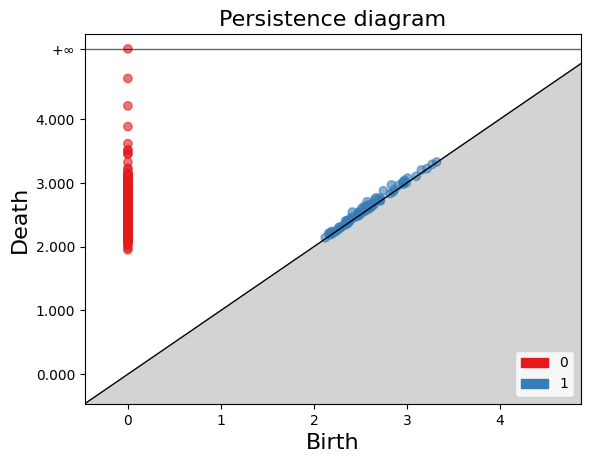

In [93]:
plot_persistance(simpl_1, max_dim=2, max_edge_length=5)

In [90]:
simpl_1 = np.stack(pt_cloud[50000:51000], axis = 0)

Dimension: 2
Num_simplices: 39420747


Plot persistence diagram: y/n y


Persistent_betti_numbers: [4, 0]


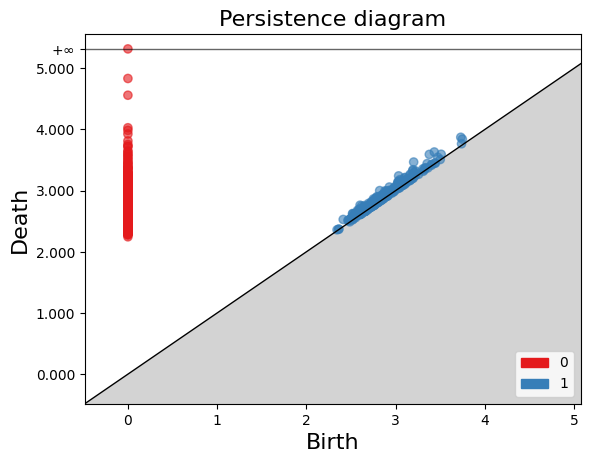

In [91]:
plot_persistance(simpl_1, max_dim=2, max_edge_length=5)

In [86]:
simpl_1 = np.stack(pt_cloud[100000:100500], axis = 0)

Dimension: 2
Num_simplices: 1068079


Plot persistence diagram: y/n y


Persistent_betti_numbers: [45, 0]


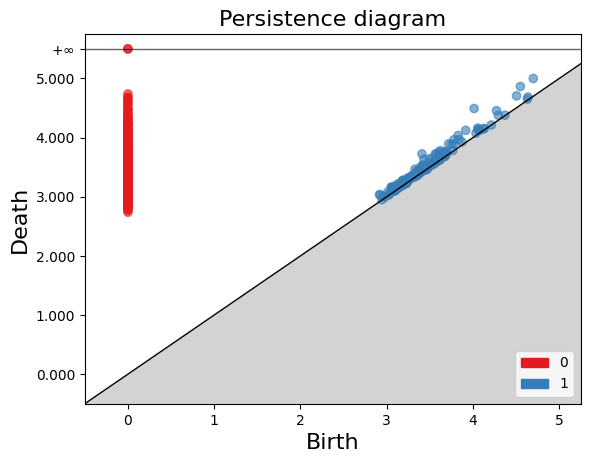

In [89]:
plot_persistance(simpl_1, max_dim=2, max_edge_length=5)

In [ ]:
pt_cloud = []

for tensor in epoch_dict[0]:

    tensors = tensor.vsplit(16)
    for pt in tensors:
        pt_cloud.append(pt.squeeze().numpy())

### Free memory

In [ ]:
def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

In [ ]:
dump_tensors()

In [ ]:
import gc

del model
del criterion
del lr_scheduler
del mlm_losses
del cosine_losses

gc.collect()
torch.cuda.empty_cache()

In [ ]:
epoch_dict